# House Price

##### During this notebook, I'm gonna explore over a dataset about Tehran's housePrice that has simply 8 features, and I will also cover the following  algorithms: Linear_regression - lightgbm - xgboost - Svr - Ridge - RandomForest - GradientBoosting - stack_gen - blended_model   

## The Goal


#####    Each row in the dataset describes the characteristics of a house. Our goal is to predict the SalePrice, given these features. Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.


## Now that we have some context, let's get started!

In [117]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
warnings.filterwarnings('ignore')
    
import os
from sklearn.metrics import r2_score

<IPython.core.display.Javascript object>

## Try a memory reduction method!

In [118]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [119]:
missing_value = {''}
df = pd.read_csv('housePrice.csv', na_values= missing_value)

## EDA

##### Each row in the dataset describes the characteristics of a house. Our goal is to predict the SalePrice, given these features. And here we preview the data we're working with, with different methods and plolts to have a better understanding over our problem.

In [120]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [121]:
df['Price'].describe()

count    3.479000e+03
mean     5.359023e+09
std      8.099935e+09
min      3.600000e+06
25%      1.418250e+09
50%      2.900000e+09
75%      6.000000e+09
max      9.240000e+10
Name: Price, dtype: float64

##### It seems that our minimum price is larger than zero. Excellent! We don't have one of those personal traits that would destroy my model!

In [122]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


## Data Cleaning

In [123]:
df = df.drop(['Price(USD)'], axis=1)
  
# convert to a appropriate data type
df['Area'] = df['Area'].str.replace(',', '')
df = df.astype({'Area': 'float'})

# drop the rows which have an non-regular Area!
index_names = df[(df['Area'] >= 10000)].index
df.drop(index_names, inplace = True)
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63.0,1,True,True,True,Shahran,1.850000e+09
1,60.0,1,True,True,True,Shahran,1.850000e+09
2,79.0,2,True,True,True,Pardis,5.500000e+08
3,95.0,2,True,True,True,Shahrake Qods,9.025000e+08
4,123.0,2,True,True,True,Shahrake Gharb,7.000000e+09


<IPython.core.display.Javascript object>

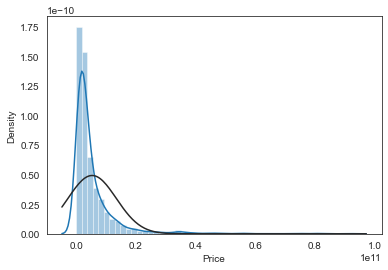

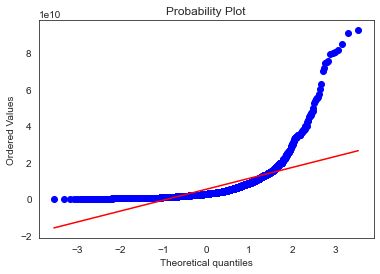

In [124]:
#histogram and normal probability plot
sns.distplot(df['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)

##### Deviate from the normal distribution. Have appreciable positive skewness. Show peakedness.

In [125]:
# Skew and kurt
print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

Skewness: 4.781029
Kurtosis: 32.432963


In [126]:
# log(1+x) transform
df["Price"] = np.log1p(df["Price"])

<IPython.core.display.Javascript object>

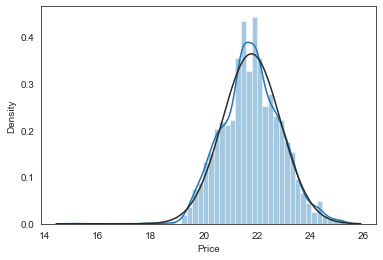

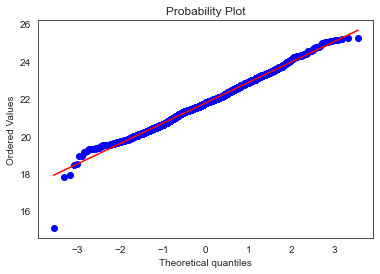

In [127]:
#histogram and normal probability plot
sns.distplot(df['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)

##### Well, now we have a normally ditributed target!

## Relationship with numerical variables

array([[<AxesSubplot:title={'center':'Area'}>,
        <AxesSubplot:title={'center':'Room'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

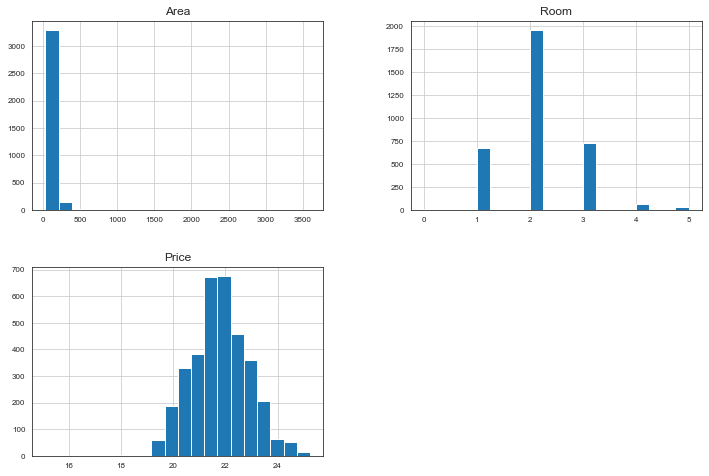

In [128]:
df.hist(figsize=(12, 8), bins=20, xlabelsize=8, ylabelsize=8)

##### we can see some relations between features. Let's go deeper and check the corelations between features.

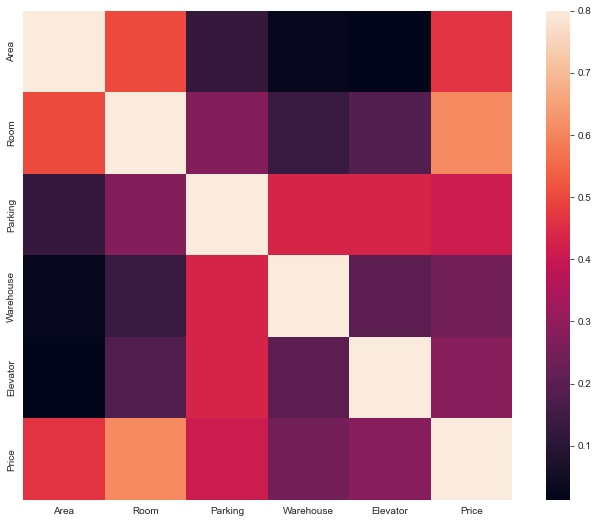

In [129]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

##### In my opinion, this heatmap is the best way to get a quick overview of our 'plasma soup' and its relationships. 

In [130]:
cols = corrmat.nlargest(5, 'Price')['Price'].index.tolist()
cols

['Price', 'Room', 'Area', 'Parking', 'Elevator']

##### These are most correlated features to price

In [131]:
corr = df.corr()
corr[corr['Price']>0.3].index

Index(['Area', 'Room', 'Parking', 'Price'], dtype='object')

##### We can drop columns that have less than 0.3 of correlation of Sale Prices.

In [132]:
# df = df[['Area', 'Room', 'Parking']]
# df.head()

##### Now we should know how much null values we have and then try to handle them.

In [133]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Address,23,0.006619
Area,0,0.000000
Room,0,0.000000
Parking,0,0.000000
Warehouse,0,0.000000
Elevator,0,0.000000
Price,0,0.000000


##### Well, in my opinion, removing these samples (rows) is a good approach here.

In [134]:
df = df.dropna(how='any',axis=0) 

In [135]:
df.isnull().sum()

Area         0
Room         0
Parking      0
Warehouse    0
Elevator     0
Address      0
Price        0
dtype: int64

##### Ok! no nan values available.

## Type Analysing

In [136]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('bool'), dtype('int64')]

In [137]:
from sklearn.compose import make_column_selector as selector
categorical_columns_selector = selector(dtype_include= ['object', 'bool']) 
categorical_columns = categorical_columns_selector(df)
categorical_columns

['Parking', 'Warehouse', 'Elevator', 'Address']

##### Here we will access the count of each categorical feature in barcharts

In [138]:
# fig ,ax = plt.subplots(2,2,figsize=(10,8))
# ax1,ax2,ax3,ax4 = ax.flatten()
# sns.countplot(data=df,x='Parking',palette='gist_rainbow',ax=ax1)
# sns.countplot(data=df,x='Warehouse',palette='viridis',ax=ax2)
# sns.countplot(data=df,x='Elevator',palette='viridis',ax=ax3)
# sns.countplot(data=df,x='Address',palette='gist_rainbow',ax=ax4

##### Here label encoding is ready to be used for those numerical categories. 

In [139]:
categories = ['Parking', 'Warehouse', 'Elevator', 'Address']

for c in categories:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63.0,1,1,1,1,156,21.338451
1,60.0,1,1,1,1,156,21.338451
2,79.0,2,1,1,1,117,20.125429
3,95.0,2,1,1,1,152,20.620679
4,123.0,2,1,1,1,150,22.669176


## Feature Engineering

In [140]:
# df['areaExp2'] = df['Area'] * df['Area']
# df['areaExp3'] = df['Area'] * df['Area'] * df['Area']
# df['areaSqrt'] = np.sqrt(df['Area'])
# price = df['Price']
# df = df.drop(['Price'], axis=1)
# df['Price'] = price

In [141]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        numeric.append(i)

In [142]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63.0,1,1,1,1,156,21.338451
1,60.0,1,1,1,1,156,21.338451
2,79.0,2,1,1,1,117,20.125429
3,95.0,2,1,1,1,152,20.620679
4,123.0,2,1,1,1,150,22.669176


In [143]:
# Find skewed numerical features
skew_features = df[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[ abs(skew_features) > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with |Skew| > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 5 numerical features with |Skew| > 0.5 :


Area         17.598163
Room          0.623973
Price         0.058953
Address      -0.319168
Elevator     -1.402540
Parking      -1.931439
Warehouse    -2.972304
dtype: float64

##### We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.

In [144]:
# Normalize skewed features
for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

In [145]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,1.641391,0.821401,4.739254,1.496119,1.5,156,21.338451
1,1.636379,0.821401,4.739254,1.496119,1.5,156,21.338451
2,1.663036,1.443866,4.739254,1.496119,1.5,117,20.125429
3,1.678863,1.443866,4.739254,1.496119,1.5,152,20.620679
4,1.698581,1.443866,4.739254,1.496119,1.5,150,22.669176


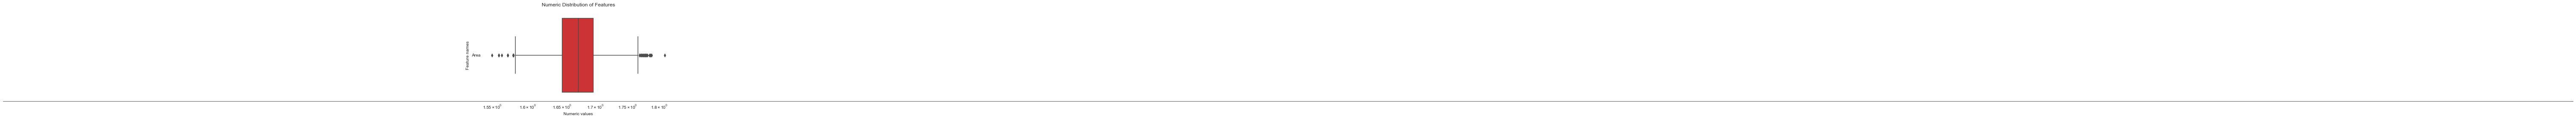

In [146]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 4))
ax.set_xscale("log")
ax = sns.boxplot(data=df[['Area']] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [147]:
## log - exponent2-3 of some features be addeed

## Scaling data

In [148]:
# using minmax scaler to scale all the datas

from sklearn.preprocessing import MinMaxScaler

# x_train,x_test,y_train,y_test=train_test_split(scaled_x,y,test_size=0.20,random_state=0)

#### Split Data Into Train And Test

In [149]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.20 MB
Memory usage after optimization is: 0.07 MB
Decreased by 63.3%


In [150]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
mc = MinMaxScaler()
scaled_x=mc.fit_transform(X)
X, x_test, train_labels, y_test = train_test_split( scaled_x, y, test_size=0.2, random_state=4)
#train #x_test #target
#X #x_test #train_labels

<IPython.core.display.Javascript object>

#### Setup cross validation and define error metrics

In [151]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [152]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

def r2Score(y, y_pred):
    r2_score(y , regr.predict(test))

## Setup models

In [153]:
#Linear Regressor
lm = LinearRegression()

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

<IPython.core.display.Javascript object>

In [154]:
scores = {}
r2_scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

In [155]:
score = cv_rmse(lm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.7589 (0.0478)


In [156]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[02:33:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:34:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

In [157]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.7764 (0.0522)


In [158]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.7593 (0.0475)


In [159]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.4951 (0.0683)


In [161]:
# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['gbr'] = (score.mean(), score.std())

## Train models

In [162]:
print('Linear_regression')
lr = lm.fit(X,train_labels)
r2_scores['Linear_regression'] = r2_score(y_test , lr.predict(x_test))
r2_scores['Linear_regression']

Linear_regression


0.5317689715194251

In [163]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))
r2_scores['stack_gen'] = r2_score(y_test , stack_gen_model.predict(x_test))
r2_scores['stack_gen']

stack_gen
[02:39:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:39:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:39:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:39:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[02:39:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fe

0.8587456003410522

In [164]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)
r2_scores['lightgbm'] = r2_score(y_test , lgb_model_full_data.predict(x_test))
r2_scores['lightgbm']

lightgbm
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


0.8430424575850011

In [165]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)
r2_scores['xgboost'] = r2_score(y_test , xgb_model_full_data.predict(x_test))
r2_scores['xgboost']

xgboost
[02:42:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


0.8599079814334107

In [166]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)
r2_scores['Svr'] = r2_score(y_test , svr_model_full_data.predict(x_test))
r2_scores['Svr']

Svr


0.5176376845666651

In [167]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)
r2_scores['Ridge'] = r2_score(y_test , ridge_model_full_data.predict(x_test))
r2_scores['Ridge']

Ridge


0.5316321051027473

In [168]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)
r2_scores['RandomForest'] = r2_score(y_test , rf_model_full_data.predict(x_test))
r2_scores['RandomForest']

RandomForest


0.8096617393174963

In [169]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)
r2_scores['GradientBoosting'] = r2_score(y_test , gbr_model_full_data.predict(x_test))
r2_scores['GradientBoosting']

GradientBoosting


0.8572322627437157

In [170]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.025 * ridge_model_full_data.predict(X)) + \
            (0.000000000001 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.675 * stack_gen_model.predict(np.array(X))))

In [173]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)
r2_scores['blended_model'] = r2_score(y_test , blended_predictions(x_test))
print('R2 score score on train data:')
print(r2_scores['blended_model'])

RMSLE score on train data:
0.2983109744034997
R2 score score on train data:
0.8636635989788533


##### Well! I got a better score by changing the coefs!

In [197]:
# Plot the predictions for each model

# sns.set_style("white")
# fig = plt.figure(figsize=(24, 12))

# ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
# for i, score in enumerate(scores.values()):
#     ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

# plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
# plt.xlabel('Model', size=20, labelpad=12.5)
# plt.tick_params(axis='x', labelsize=13.5)
# plt.tick_params(axis='y', labelsize=12.5)

# plt.title('Scores of Models', size=20)

# plt.show()

#### All of the scores recieved from cv_rmse 

In [174]:
scores

{'lgb': (0.7589184428452206, 0.047777739387560976),
 'xgb': (0.400769308161597, 0.07018777153202294),
 'svr': (0.7764017340417074, 0.052222693083468316),
 'ridge': (0.7593202882099287, 0.04749930939678904),
 'rf': (0.49509947133700316, 0.06832974405394826),
 'blended': (0.2983109744034997, 0)}

In [175]:
min(scores.values())

(0.2983109744034997, 0)

#### All of the scores recieved from R2_Scores 

In [176]:
r2_scores

{'Linear_regression': 0.5317689715194251,
 'stack_gen': 0.8587456003410522,
 'lightgbm': 0.8430424575850011,
 'xgboost': 0.8599079814334107,
 'Svr': 0.5176376845666651,
 'Ridge': 0.5316321051027473,
 'RandomForest': 0.8096617393174963,
 'GradientBoosting': 0.8572322627437157,
 'blended_model': 0.8636635989788533}

#### Better scores by scaling feature (not target)

In [177]:
max(r2_scores.values())

0.8636635989788533

#### Well, as we can see, the best score is 0.86366 that belongs to 'xgboost'!

In [52]:
# r2_scores = r2_scores.values()
# models = r2_scores.keys() 
# a = pd.DataFrame(test_id, columns=['r2_scores'])
# a

In [51]:
# r2_scores.keys()

## Submit predictions

In [ ]:
# Read in sample_submission dataframe

# submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
# submission.shape

In [159]:
# Append predictions from blended models
# submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [ ]:
# Fix outleir predictions
#q1 = submission['SalePrice'].quantile(0.0045)
#q2 = submission['SalePrice'].quantile(0.99)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
#submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
# Scale predictions
# submission['SalePrice'] *= 1.001619
# submission.to_csv("submission_regression2.csv", index=False)